# Download data

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('anonymized.csv')
data.head()

,Date,Amount
0,25May2016,54241.35
1,29May2017,54008.83
2,30Jun2017,54008.82
3,05Jan2017,52704.37
4,23Feb2017,52704.36


# Build the density model for the number of transactions that occur in a single motnh

In [56]:
data.shape

(2518, 2)

In [57]:
data_copy1 = data.copy()

In [58]:
data_copy1['Date'] = data_copy1['Date'].str[2:]
data_copy1['Date'][:5]

0    May2016
1    May2017
2    Jun2017
3    Jan2017
4    Feb2017
Name: Date, dtype: object

In [59]:
# the numbers of transactions occuring in all months 
X = data_copy1['Date'].value_counts().values
print(X)

[106  96  88  86  78  75  73  73  68  64  64  64  62  61  59  59  59  58
  57  55  54  53  52  52  51  48  48  47  45  45  44  44  43  41  40  40
  39  38  38  36  34  33  32  32  27  23  16  10   8]


I will use the kernel density estimation and tuning the parameter `kernel` and `bandwidth` using LOOCV (in this case) or k-fold CV (in the other two models). Because `sklearn` only supports sampling for `gaussian` and `tophat` kernels, the candidates for kernels only contain these two (i.e., `linear`, `tophat`, etc. are not considered).

I use LOOCV (as opposed to k-fold) because the data set (`X`) is small and using LOOCV won't take much time.

The parameters are chosen so that the log likelihood of the held out parts are maximized.

In [60]:
# adapted from 
# https://jakevdp.github.io/PythonDataScienceHandbook/
# 05.13-kernel-density-estimation.html
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors.kde import KernelDensity
import numpy as np
parameters = {'kernel':('gaussian', 'tophat'),
             'bandwidth': 10 ** np.linspace(-2, 2, 100) }
grid = GridSearchCV(KernelDensity(),
                    parameters,
                    cv=LeaveOneOut(len(X)))

grid.fit(X[:, None]);

In [61]:
grid.best_params_

{'bandwidth': 14.174741629268063, 'kernel': 'tophat'}

In [62]:
kde1 = KernelDensity(kernel=grid.best_params_['kernel'], 
                     bandwidth=grid.best_params_['bandwidth']).fit(np.array(X).reshape((-1,1)))

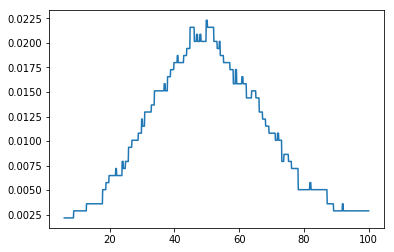

In [63]:
import matplotlib.pyplot as plt
X_plot = np.linspace(6, 100, 1000)[:, np.newaxis]
log_dens = kde1.score_samples(X_plot)
plt.plot(X_plot[:,0], np.exp(log_dens))

# Build the density model for the day in the month that a transaction will occur on.

In [64]:
data_copy2 = data.copy()

In [65]:
data_copy2['Date'] = data_copy2['Date'].str[:2]
data_copy2['Date'][:5]

0    25
1    29
2    30
3    05
4    23
Name: Date, dtype: object

In [66]:
data_copy2['Date'] = pd.to_numeric(data_copy2['Date'])

In [67]:
X2 = data_copy2['Date'].values
print(X2)

[25 29 30 ... 22 23 19]


In [68]:
parameters = {'kernel':('gaussian', 'tophat'),
             'bandwidth': 10 ** np.linspace(-1, 1, 100) }
grid = GridSearchCV(KernelDensity(),
                    parameters,
                    cv=5)
grid.fit(X2[:, None]);

In [69]:
grid.best_params_

{'bandwidth': 0.1, 'kernel': 'tophat'}

The optimal bandwidth is the lowest in the considered interval. Therefore, it is natural to expand the interval to see if there is any better bandwidth.

In [70]:
parameters['bandwidth'] = 10 ** np.linspace(-2, 2, 100)
grid = GridSearchCV(KernelDensity(),
                    parameters,
                    cv=5)
grid.fit(X2[:, None]);
grid.best_params_

{'bandwidth': 0.01, 'kernel': 'tophat'}

We see that the bandwidth still takes the smallest value in the interval. The reason is that because there are only 31 distinct values (corresponding to a maximum of 31 days in a month), while the list of data contains more than 4,000 elements, it is highly likely that in k-fold cross validation, all the data in the validation set has been observed in the training set so that the only way to maximize the likelihood is that to minimize the bandwidth which has the effect of shrinking the density at non-integer points to 0. Therefore, we can never find an optimal value for bandwidth as it keeps shrinking.

Therefore I will use the histogram distribution of the data `X2` instead (simply drawing from the list with equal probability for each element; this will be done in the sampling question.)

(array([290., 197., 210., 191., 189., 199., 241., 276., 384., 341.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

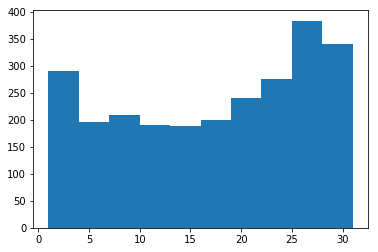

In [71]:
plt.hist(X2)

# Build the density model for the transaction size

In [72]:
X = np.array(list(data['Amount'].values))
print(X)

[ 54241.35  54008.83  54008.82 ... -28400.   -35570.   -41054.95]


In [73]:
parameters = {'kernel':('gaussian', 'tophat'),
             'bandwidth': 10 ** np.linspace(-10, 10, 100) }
grid = GridSearchCV(KernelDensity(),
                    parameters,
                    cv=5)
grid.fit(X[:, None]);

In [74]:
grid.best_params_

{'bandwidth': 8697.490026177835, 'kernel': 'gaussian'}

In [75]:
kde3 = KernelDensity(kernel='gaussian', 
                     bandwidth=grid.best_params_['bandwidth']).fit(np.array(X).reshape((-1,1)))

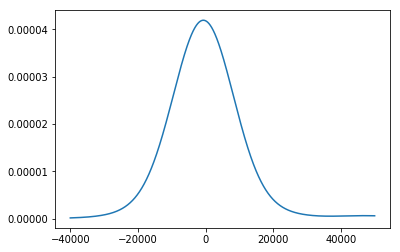

In [76]:
import matplotlib.pyplot as plt
X_plot = np.linspace(-40000, 50000, 10000)[:, np.newaxis]
log_dens = kde3.score_samples(X_plot)
plt.plot(X_plot[:,0], np.exp(log_dens))

# Sampling from these density models, create a fictitious month of personal transactions.


In [78]:
# sample the number of transactions in the month:
num_trans = int(round(kde1.sample()[0,0]))
print(num_trans)

89


In [79]:
# sample the days in the month that the transactions occur on:
days = np.random.choice(X2, num_trans)
days_list = list(days)
print(days_list)

[25, 24, 24, 24, 27, 12, 29, 12, 25, 19, 27, 14, 3, 31, 9, 31, 22, 6, 3, 19, 19, 6, 30, 22, 10, 31, 9, 23, 17, 25, 5, 1, 3, 7, 1, 25, 17, 24, 21, 22, 28, 9, 24, 1, 19, 5, 28, 12, 12, 14, 29, 4, 18, 4, 17, 24, 27, 22, 3, 18, 20, 7, 8, 26, 1, 26, 1, 23, 1, 7, 4, 25, 1, 23, 27, 16, 30, 11, 22, 26, 12, 29, 20, 20, 13, 9, 22, 17, 7]


In [82]:
# sample the transaction amount
amounts = kde3.sample(num_trans)
print(amounts)

[[ 1.33504548e+04]
 [ 2.64170214e+03]
 [-1.68255460e+03]
 [ 5.69162172e+03]
 [ 4.75793860e+04]
 [ 1.88429939e+03]
 [-6.22548631e+02]
 [ 7.92968535e+03]
 [-9.25962020e+02]
 [ 1.13950046e+04]
 [ 2.50681884e+03]
 [-9.64804589e+03]
 [ 4.26264021e+03]
 [ 2.41061340e+03]
 [ 1.00615456e+04]
 [-6.73267545e+03]
 [ 5.28096226e+02]
 [ 4.90646612e+03]
 [ 1.96231470e+04]
 [ 1.21927280e+03]
 [ 1.44254559e+04]
 [-1.17236814e+04]
 [ 2.37994358e+03]
 [-4.62649812e+03]
 [ 1.26037543e+04]
 [ 9.60620052e+03]
 [-3.35288098e+03]
 [ 1.01202824e+04]
 [ 2.81391280e+04]
 [-4.78995869e+03]
 [ 7.75585866e+03]
 [-1.69587833e+04]
 [-1.50741585e+04]
 [ 2.96658225e+03]
 [-8.97239814e+03]
 [ 1.31430020e+03]
 [-4.31449814e+03]
 [ 5.79443421e+02]
 [ 7.09943955e+03]
 [ 8.42669478e+03]
 [ 4.66523753e+03]
 [ 1.40209040e+04]
 [ 6.38843226e+03]
 [-5.85970660e+02]
 [-4.90980479e+03]
 [ 7.66942637e+03]
 [-3.54642742e+03]
 [ 3.94132561e+03]
 [ 1.81935888e+03]
 [ 9.28306864e+03]
 [ 3.46443091e+03]
 [ 8.66703453e+03]
 [-1.8276784

In [83]:
fictitious_data = {'day':days_list, 'amount':list(amounts[:,0])}
df = pd.DataFrame(fictitious_data)

In [84]:
df.head()

,day,amount
0,25,13350.454782
1,24,2641.702135
2,24,-1682.554597
3,24,5691.621716
4,27,47579.386025


# Explain what flaws still remain in your model that a forensic accountant might be able to find and determine that this was a fraudulent set of transactions.

The way the transactions are generated above assumes many independences. As long as these assumptions do not hold and there is a discrepency between the generated set of transactions' distributions and those of the original data sets, the set may be flagged as fradulent. Some of the assumptions are:

1. The transaction size is independent of the day on which the transaction happens (this is reflected by the way we just naively pair the day and the amount together in the order of their appearance.) This could be wrong. For example, let us look at the distribution of the transaction amounts on day 1 and day 9 of a month:

In [85]:
data_copy4 = data.copy()

In [86]:
data_copy4['Date'] = data_copy4['Date'].str[:2]
data_copy4['Date'] = pd.to_numeric(data_copy4['Date'])

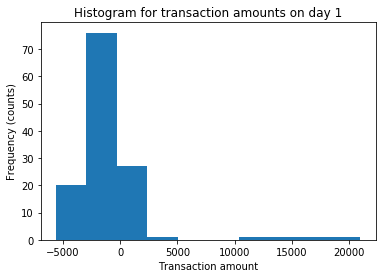

In [87]:
data_day1 = data_copy4.loc[data_copy4['Date'] == 1]
plt.hist(data_day1['Amount'])
plt.xlabel('Transaction amount')
plt.ylabel('Frequency (counts)')
plt.title('Histogram for transaction amounts on day 1')
plt.show()

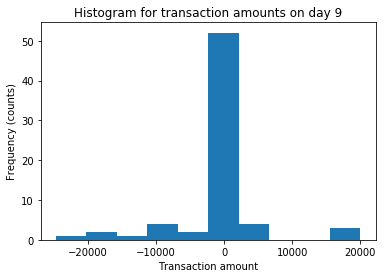

In [88]:
data_day9 = data_copy4.loc[data_copy4['Date'] == 9]
plt.hist(data_day9['Amount'])
plt.xlabel('Transaction amount')
plt.ylabel('Frequency (counts)')
plt.title('Histogram for transaction amounts on day 9')
plt.show()

We can see that the two distributions look quite different, because on day 9, negative amounts as large as -20,000 happen more often, while on day 1, no amounts less than -5000 occurs.

The follwing plot gives a more holistic view of the distribution of transaction amounts on each day.

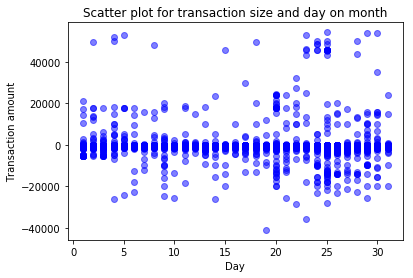

In [89]:
plt.plot(data_copy4['Date'], data_copy4['Amount'],'bo', alpha = 0.5)
plt.title('Scatter plot for transaction size and day on month')
plt.xlabel('Day')
plt.ylabel('Transaction amount')
plt.show()

2. The number of transactions, the transaction size, and the days on which the transactions occur, are independent of the month in year (no distinction between January and December, for example).

3. The number of transactions in a month is indepedent of the value of each transaction in that month.

4. In building the density estimation for the day in the month that a transaction will occur on, we assume that all the months have the same set of days (from 1 to 31), while in fact this is not true (April does not have day 31 for example). We may tackle this problem by saying that when generating transaction data for April (or June, September, November), whenever the model generates the day 31 we discard them. Because of this discarding, the overal probability of a transaction happens on day 31 across all months is lower than that probability in the real, non-fraud data set and the accountant may notice this discrepancy.